In [1]:
using DynamicGrids, Crayons, ColorSchemes, Colors, DynamicGridsGtk, Distributions, Random, Statistics, 
    LinearAlgebra, Setfield

num_species = 10; # Number of species
num_hab = 5; # Number of habitat types
beta_coeff = 0.01*ones(num_species, num_species); # Competition coefficients
mean_disp_dist = 1; # Mean dispersal distance
seed_prob = 0.95*ones(num_species); # Probability a seed of a species survives 
hab_mat = ones(num_species, num_hab); # Affinity matrix for habitats
species_distribution = zeros(num_species);

In [41]:
death_hf = let betas = beta_coeff, num_species = num_species
    Neighbors{:species}(Moore(2)) do data, hood, state, I
        if state == 0
            return(state)
        end
        
        vals = neighbors(hood)       
        abund = [sum(vals .== i) for i in 1:num_species]      
        
        survival_prob = (exp.(-betas[state,:]' * abund))        
        
        if rand() > survival_prob
            0
        else
            state
        end
    end
    end;
        
birth_g_hf = let num_species = num_species, mean_disp_dist = mean_disp_dist, seed_prob = seed_prob,
    hab_mat = hab_mat
    Neighbors{Tuple{:species, :habitat}, :species}(Moore(4)) do data, hood, (spec, hab), I
        if spec == 0
            vals = collect(neighbors(hood))
            dist = collect(distances(hood).^2)
            
            ker = exp.(-dist/2/mean_disp_dist^2)
            weights = [sum(ker[vals .== i]) for i in 1:num_species] .* hab_mat[:, hab]
            
            new_seed = wsample(1:10, weights)
            
            if rand() > seed_prob[new_seed]
                0
            else
                new_seed
            end
        else
            spec
        end
    end
    end;

death_nonspatial = let betas = beta_coeff, num_species = num_species
    Cell{:species}() do data, state, I
        if state == 0
            return(state)
        end
        
        grid = DynamicGrids.gridview(data[:species])
        dist = [sum(grid .== i) for i in 1:num_species]/104
        
        survival_prob = (exp.(-betas[state,:]' * dist))        
        
        if rand() > survival_prob
            0
        else
            state
        end
    end
    end;

birth_nonspatial = let num_species = num_species, mean_disp_dist = mean_disp_dist, seed_prob = seed_prob,
    hab_mat = hab_mat
    Cell{Tuple{:species, :habitat}, :species}() do data, (spec, hab), I
        
        if spec == 0   
            grid = DynamicGrids.gridview(data[:species])
            dist = [sum(grid .== i) for i in 1:num_species]
            
            weights = dist .* hab_mat[:, hab]
            
            new_seed = wsample(1:10, weights)
            
            if rand() > seed_prob[new_seed]
                0
            else
                new_seed
            end
        else
            spec
        end
    end
    end;

In [ ]:
Random.seed!(1);
init = (species = rand(1:10, 100, 100), habitat = rand(1:5, 100, 100));

output = GifOutput(init; 
    filename="comp_gauss.gif", 
    tspan=1:200, 
    fps=25, 
    minval = 0, maxval = num_species,
    scheme=ColorSchemes.rainbow,
    zerocolor=RGB24(0.0)
);

@time sim!(output, (death_hf, birth_g_hf); boundary = Wrap());

In [ ]:
Random.seed!(1)
species = rand(1:10, 100, 100)
habitat = rand(1:5, 100, 100)

extent = Extent(; init = (species = species, habitat = habitat), tspan = 1:2)
rules = Ruleset(death_hf, birth_g_hf; boundary = Wrap())

simdata = DynamicGrids.SimData(extent, rules)

t = 0
tmax = 1000
prev_steps = 50 # Previous steps to count in checking distribution
prev_dist = zeros(prev_steps, num_species + 1) # Stores previous 'prev_steps' distributions
threshold = 100*100*0.02 # Threshold for how much the L1 norm should differ before breaking out of the loop

@time while t < tmax
    simdata = step!(simdata)
    
    grid = DynamicGrids.gridview(simdata[:species])
    species_dist = [sum(grid .== i) for i in 0:10]
        
    prev_dist[t % prev_steps + 1, :] = species_dist
    prev_dist_mean = mean(prev_dist; dims = 1)
    
    if t % 10 == 0
        println(norm(mean(prev_dist; dims = 1) - reshape(species_dist, 1, 11), 1))
    end
    
    if norm(mean(prev_dist; dims = 1) - reshape(species_dist, 1, 11), 1) < threshold
        println("Broke out of loop, t = ", t)
        break
    end
    
    t += 1
end

In [40]:
Random.seed!(1)

steps = 5000
abund = zeros(50, 11)

for k in 1:50
    println(k)
    
    species = rand(1:10, 50, 50)
    habitat = rand(1:5, 50, 50)

    extent = Extent(; init = (species = species, habitat = habitat), tspan = 1:2)
    rules = Ruleset(death_hf, birth_g_hf; boundary = Wrap())

    simdata = DynamicGrids.SimData(extent, rules)

    for j in 1:steps
        simdata = step!(simdata)
        
    end 
    
    grid = DynamicGrids.gridview(simdata[:species])
    abund[k, :] = [sum(grid .== i) for i in 0:10]
        
    CSV.write("full_spatial.csv", Tables.table(abund), writeheader = false)
    
end



1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50


In [43]:
Random.seed!(1)

steps = 5000
abund = zeros(50, num_species + 1)

for k in 1:50
    println(k)
    
    species = rand(1:10, 50, 50)
    habitat = rand(1:5, 50, 50)

    extent = Extent(; init = (species = species, habitat = habitat), tspan = 1:2)
    rules = Ruleset(death_hf, birth_nonspatial; boundary = Wrap())

    simdata = DynamicGrids.SimData(extent, rules)

    for j in 1:steps
        simdata = step!(simdata)
        
    end 
    
    grid = DynamicGrids.gridview(simdata[:species])
    abund[k, :] = [sum(grid .== i) for i in 0:10]
        
    CSV.write("nonspatial_birth.csv", Tables.table(abund), writeheader = false)
end
     

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50


In [45]:
Random.seed!(1)
species = rand(1:10, 50, 50)
habitat = rand(1:5, 50, 50)

extent_ns = Extent(; init = (species = species, habitat = habitat), tspan = 1:2)
rules_ns = Ruleset(death_nonspatial, birth_nonspatial; boundary = Wrap())

simdata_ns = DynamicGrids.SimData(extent_ns, rules_ns)

steps = 5000
abund = zeros(50, num_species + 1)

@time for k in 1:50
    println(k)
    
    species = rand(1:10, 50, 50)
    habitat = rand(1:5, 50, 50)

    extent = Extent(; init = (species = species, habitat = habitat), tspan = 1:2)
    rules = Ruleset(death_nonspatial, birth_nonspatial; boundary = Wrap())

    simdata = DynamicGrids.SimData(extent, rules)

    for j in 1:steps
        simdata = step!(simdata)
        
    end 
    
    grid = DynamicGrids.gridview(simdata[:species])
    abund[k, :] = [sum(grid .== i) for i in 0:10]
        
    CSV.write("full_nonspatial.csv", Tables.table(abund), writeheader = false)
end
     

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
25153.662549 seconds (25.31 G allocations: 32.437 TiB, 30.32% gc time, 0.00% compilation time)


In [34]:
using CSV, Tables

CSV.write("test.csv", Tables.table(rand(1:10, 10, 10)), writeheader = false)

"test.csv"

In [66]:
using DataFrames

full_spatial = Matrix(CSV.read("full_spatial.csv", DataFrame; header = false));
full_nonspatial = Matrix(CSV.read("full_nonspatial.csv", DataFrame; header = false));
nonspatial_birth = Matrix(CSV.read("nonspatial_birth.csv", DataFrame; header = false)[1:50, :]);


In [67]:
richness = zeros(50, 3)

for i in 1:50
    richness[i, 1] = sum(full_spatial[i, :] .!= 0)
    richness[i, 2] = sum(full_nonspatial[i, :] .!= 0)
    richness[i, 3] = sum(nonspatial_birth[i, :] .!= 0)
end

using Statistics

println("Mean:", mean(richness, dims = 1))
println("Var:", var(richness, dims = 1))
    

Mean:[4.18 3.24 3.12]
Var:[0.8444897959183671 0.7983673469387755 0.5159183673469387]


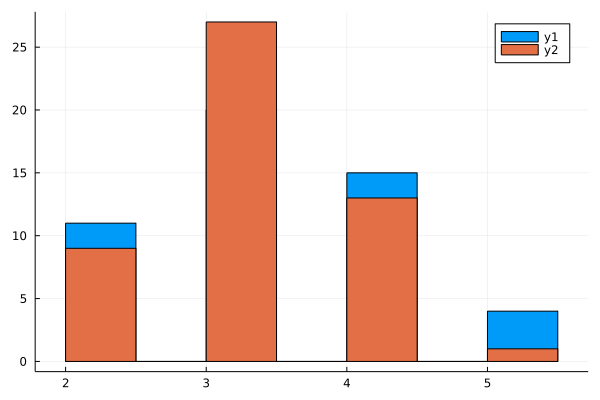

In [74]:
using Plots

histogram(richness[:,2:3])